## Section 3 – Unsupervised learning – clustering

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from wordcloud import WordCloud

In [41]:
df = pd.read_parquet("df_tfidf.parquet")

X = df.drop(columns=["Set_Fingerprint"])
X

,enable,system,sh,cat,proc,mounts,bin,busybox,cd,dev,...,top,sleep,tar,passwd,nc,mkdir,unix,mv,nohup,tsm
0,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.0,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000
1,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.0,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000
2,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.0,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000
3,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.0,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000
4,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.0,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.0,0.000000,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821
233031,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.0,0.000000,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821
233032,0.128896,0.065000,0.000000,0.000000,0.00000,0.238360,0.000000,0.0,0.000000,0.238736,...,0.0,0.000000,0.321332,0.064319,0.0,0.193360,0.0,0.450819,0.000000,0.06446
233033,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.0,0.000000,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821


## 3.1 Determine the number of clusters

### 3.1.1 K-means

In [ ]:
# Within-Cluster Sum of Squares (WCSS): For each value of k (number of clusters), 
# calculate the sum of squared distances (WCSS) between points and their respective cluster centroids.
wcss = []
silhouette_scores_kmeans = []
n_cluster_list_kmeans = []


# Compute WCSS for different values of k
for n_clusters in range(3, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit(X)
    
    wcss.append(kmeans.inertia_)  # WCSS is stored in the `inertia_` attribute
    silhouette_scores_kmeans.append(silhouette_score(X, kmeans.labels_))
    n_cluster_list_kmeans.append(n_clusters)



In [ ]:
print(silhouette_scores_kmeans)
print(wcss)

In [ ]:


best_silhouette_kmeans= np.max(silhouette_scores_kmeans) # Best silhouette
best_n_cluster_kmeans = n_cluster_list_kmeans[np.argmax(silhouette_scores_kmeans)] # Get n_clusters related to the best silhouette
print("best k: ",best_n_cluster_kmeans, ", corresponding silhouette: ", best_silhouette_kmeans)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(n_cluster_list_kmeans, wcss, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Kmeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(3, 8))

# Plot the Silhouette Method
plt.subplot(1, 2, 2)
plt.plot(n_cluster_list_kmeans, silhouette_scores_kmeans, marker='o', linestyle='--', color='orange')
plt.scatter(best_n_cluster_kmeans, best_silhouette_kmeans, color='r', marker='x', s=90)
plt.title('Silhouette Method for Kmeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(3, 8))

plt.tight_layout()
plt.show()

### 3.1.2 GMM

In [ ]:
n_cluster_list_gmm =[]
silhouette_list_gmm = []
log_l_list=[]

for n_clusters in range(3, 10):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(X)
    n_cluster_list_gmm.append(n_clusters)
    silhouette_list_gmm.append(silhouette_score(X, cl_labels))
    log_l_list.append(gmm.score(X))


In [ ]:
print(silhouette_list_gmm)
print(log_l_list)
best_silhouette_gmm= np.max(silhouette_list_gmm) # Best silhouette
best_n_cluster_gmm = n_cluster_list_gmm[np.argmax(silhouette_list_gmm)] # Get n_clusters related to the best silhouette
print("best k: ",best_n_cluster_gmm, ", corresponding silhouette: ", best_silhouette_gmm)

# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm, log_l_list, marker='o', markersize=5)
plt.grid()
plt.title('Elbow Method for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm, silhouette_list_gmm, marker='o', markersize=5)
plt.scatter(best_n_cluster_gmm, best_silhouette_gmm, color='r', marker='x', s=90)
plt.grid()
plt.title('Silhouette Method for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

## 3.2 Tuning other hyperparameters

In [ ]:
param_grid_kmeans = {
    'init': ['k-means++', 'random'],
    'n_init':  [1, 4, 10],
    'max_iter':  [50, 100, 150],
}

kmeans = KMeans(n_clusters=8, random_state=42)
grid_search_kmeans = GridSearchCV(kmeans, param_grid = param_grid_kmeans, cv=3)
grid_search_kmeans.fit(X)

best_params_kmeans = grid_search_kmeans.best_params_
print("Best parameters:", best_params_kmeans)


In [ ]:
kmeans_t = KMeans(n_clusters = 8, init = best_params_kmeans['init'], n_init = best_params_kmeans['n_init'], max_iter = best_params_kmeans['max_iter'], random_state=42)
cl_labels_tuned = kmeans_t.fit_predict(X)
    
silhouette_kmeans_tuned = silhouette_score(X, kmeans_t.labels_)
wcss = (kmeans_t.inertia_)
print("Silhouette: ", silhouette_kmeans_tuned)
print("Inertia: ", wcss)

### 3.2.2 GMM

In [10]:
param_grid_gmm = {
    'covariance_type': ['full', 'spherical'],
    'tol': [1e-3, 1e-4], 
    'max_iter': [50, 100, 150],
}

def silhouette_scoring(gmm, X):
    labels = gmm.fit_predict(X)
    return silhouette_score(X, labels)

# Create GaussianMixture object
gmm_to_tune = GaussianMixture(n_components=8,random_state=42)

grid_search_gmm = GridSearchCV(gmm_to_tune, param_grid_gmm, scoring = silhouette_scoring, cv = 3)
grid_search_gmm.fit(X)

best_params_gmm = grid_search_gmm.best_params_
print("Best parameters:", best_params_gmm)

Best parameters: {'covariance_type': 'full', 'max_iter': 50, 'tol': 0.001}


In [12]:
gmm_t = GaussianMixture(n_components = 10, random_state=42, covariance_type=best_params_gmm['covariance_type'], max_iter=best_params_gmm['max_iter'], tol=best_params_gmm['tol'])
gmm_label_t = gmm_t.fit_predict(X)
silhouette_gmm_tuned = silhouette_score(X, gmm_label_t)
log_l_t = (gmm_t.score(X))
print("Silhouette: ", silhouette_gmm_tuned)
print("Log-l: ", log_l_t)

Silhouette:  0.8874511047300687
Log-l:  238.7523602706648


## 3.3 t-SNE visualization

In [16]:
features = pd.DataFrame(X)
tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(features.values)
tsne_results__df = pd.DataFrame(tsne)
tsne_results__df

,0,1
0,72.277657,-0.043770
1,72.277657,-0.043770
2,72.277657,-0.043770
3,72.277657,-0.043770
4,72.277657,-0.043770
...,...,...
233030,-69.362404,84.269600
233031,-69.362404,84.269600
233032,26.426920,-4.449244
233033,-69.025154,83.439423


In [ ]:
# K-means
df_tsne_kmeans = pd.DataFrame(tsne_results__df)
df_tsne_kmeans["cluster"] = kmeans_label_t
df_tsne_kmeans.columns = ["x1", "x2", "cluster"]

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne_kmeans, x='x1', y='x2', hue='cluster', legend="full", palette='deep')
plt.title('t-SNE Visualization of KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [21]:
# GMM
df_gmm_tsne = pd.DataFrame(tsne_results__df)
df_gmm_tsne["cluster"] = gmm_label_t
df_gmm_tsne.columns = ["x1", "x2", "cluster"]
df_gmm_tsne

,x1,x2,cluster
0,72.277657,-0.043770,2
1,72.277657,-0.043770,2
2,72.277657,-0.043770,2
3,72.277657,-0.043770,2
4,72.277657,-0.043770,2
...,...,...,...
233030,-69.362404,84.269600,0
233031,-69.362404,84.269600,0
233032,26.426920,-4.449244,9
233033,-69.025154,83.439423,0


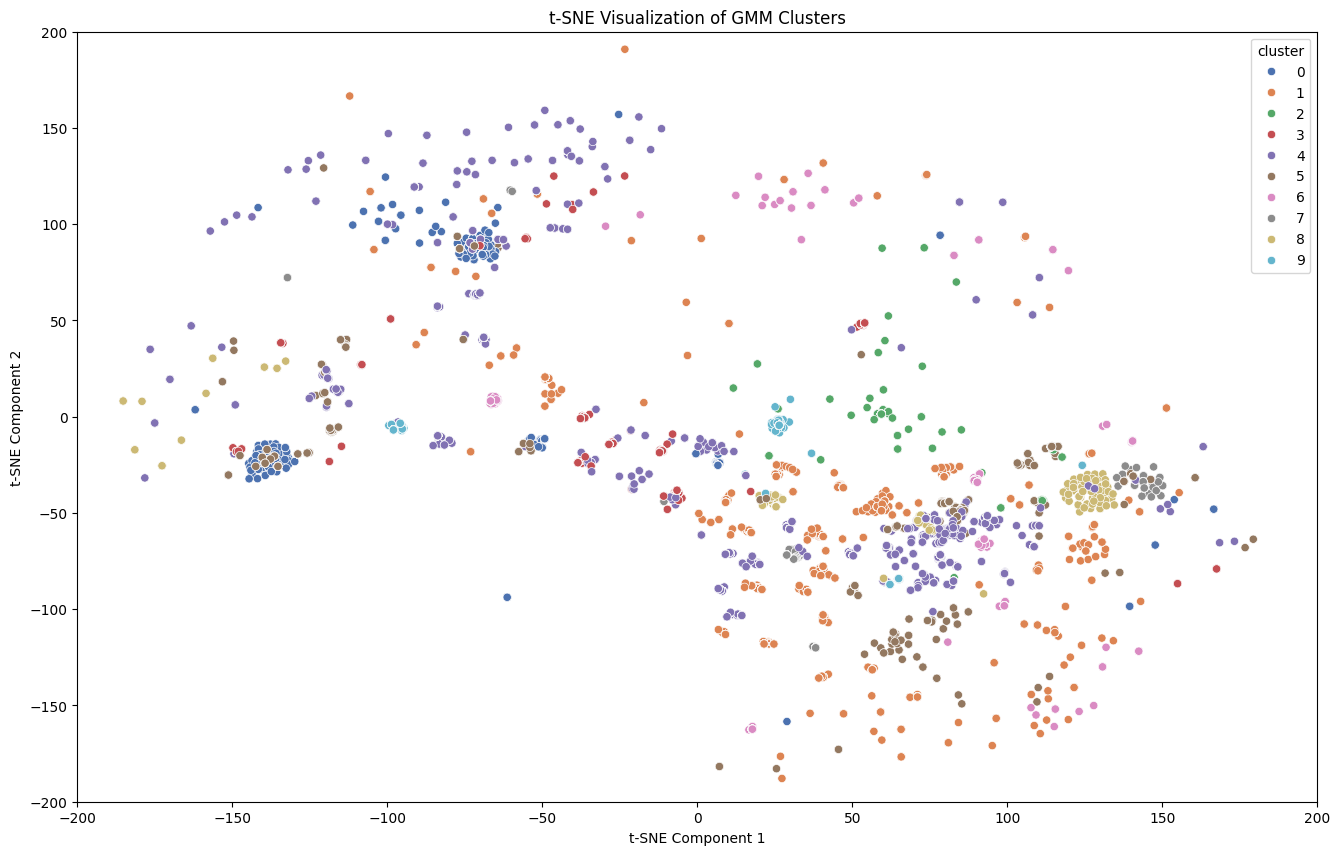

In [40]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df_gmm_tsne, x='x1', y='x2', hue='cluster', legend="full", palette='deep')
plt.title('t-SNE Visualization of GMM Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.xlim(-200, 200)  # Zoom in on x-axis
plt.ylim(-200, 200)  # Zoom in on y-axis
plt.show()

## 3.4 Cluster analysis

### 3.4.1 GMM wordclouds

In [45]:
df_cluster = pd.DataFrame(X)
df_cluster["cluster_labels_gmm"] = gmm_label_t
df_cluster

,enable,system,sh,cat,proc,mounts,bin,busybox,cd,dev,...,sleep,tar,passwd,nc,mkdir,unix,mv,nohup,tsm,cluster_labels_gmm
0,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2
1,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2
2,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2
3,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2
4,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.131995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.000000,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0
233031,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.000000,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0
233032,0.128896,0.065000,0.000000,0.000000,0.00000,0.238360,0.000000,0.0,0.000000,0.238736,...,0.000000,0.321332,0.064319,0.0,0.193360,0.0,0.450819,0.000000,0.06446,9
233033,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.000000,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0


In [46]:
# Group by cluster
cluster_groups = df_cluster.groupby('cluster_labels_gmm').mean()  # Average TF-IDF per cluster

# Select top 10 words for each cluster
top_words_by_cluster = {}

for cluster in cluster_groups.index:
    cluster_tfidf = cluster_groups.loc[cluster]
    top_words = cluster_tfidf.sort_values(ascending=False).head(10)
    top_words_by_cluster[cluster] = top_words
    print(f"Cluster {cluster} - Top 10 Words:")
    print(top_words)
    print()

Cluster 0 - Top 10 Words:
mv        0.477378
rm        0.408108
tar       0.339866
dev       0.252801
mounts    0.252402
wget      0.248803
tmp       0.205138
mkdir     0.204751
uname     0.204446
bash      0.201446
Name: 0, dtype: float64

Cluster 1 - Top 10 Words:
tar       0.503942
unix      0.427149
mv        0.356508
bin       0.239375
free      0.213465
top       0.213394
ss        0.210584
rm        0.177778
head      0.165378
mounts    0.165017
Name: 1, dtype: float64

Cluster 2 - Top 10 Words:
sh       0.657239
proc     0.526164
print    0.364018
root     0.131835
cd       0.131716
dd       0.131711
sleep    0.131458
nohup    0.130344
echo     0.129136
cat      0.120551
Name: 2, dtype: float64

Cluster 3 - Top 10 Words:
mv        0.431339
rm        0.368749
tar       0.307447
dev       0.228420
mounts    0.228060
wget      0.227863
ss        0.221125
bash      0.187989
mkdir     0.185004
tmp       0.184745
Name: 3, dtype: float64

Cluster 4 - Top 10 Words:
tar       0.301055
m

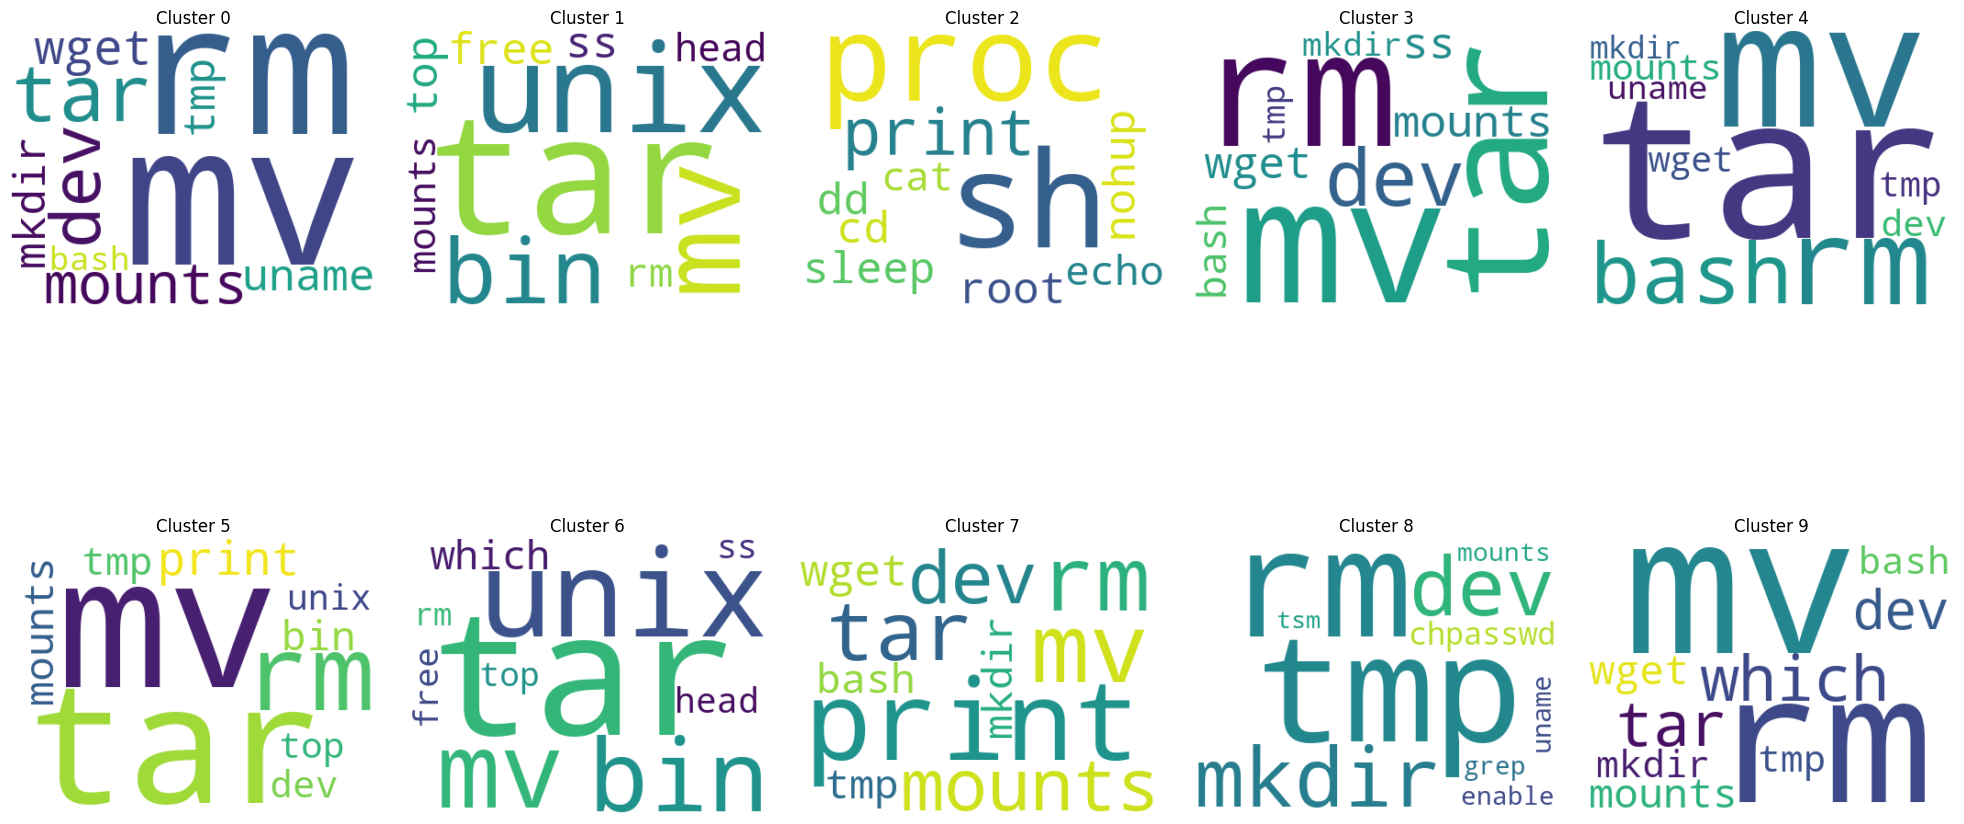

In [49]:
plt.figure(figsize=(20, 12))

for i, (cluster, top_words) in enumerate(top_words_by_cluster.items()):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(top_words)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster}')

plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Horizontal and vertical spacing

plt.tight_layout(pad=2)
plt.show()

### 3.4.2 K-means wordcloud

In [ ]:
df_cluster = pd.DataFrame(X)
df_cluster["cluster_labels_kmeans"] = kmeans_label_t

In [ ]:
# Group by cluster
cluster_groups_kmeans = df_cluster.groupby('cluster_labels_kmeans').mean()

# Select top 10 words for each cluster
top_words_by_cluster_kmeans = {}

for cluster in cluster_groups_kmeans.index:
    cluster_tfidf = cluster_groups.loc[cluster]
    top_words = cluster_tfidf.sort_values(ascending=False).head(10)
    top_words_by_cluster_kmeans[cluster] = top_words
    print(f"Cluster {cluster} - Top 10 Words:")
    print(top_words)
    print()

In [ ]:
plt.figure(figsize=(20, 12))

for i, (cluster, top_words) in enumerate(top_words_by_cluster_kmeans.items()):
    plt.subplot(2, 5, i + 1)
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(top_words)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster}')

plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Horizontal and vertical spacing

plt.tight_layout(pad=2)
plt.show()

## 3.5 Do clusters reflect intent division

In [51]:
df_cluster_intents = pd.DataFrame(df_cluster)
df_cluster_intents['Set_Fingerprint'] = df['Set_Fingerprint']
df_cluster_intents

,enable,system,sh,cat,proc,mounts,bin,busybox,cd,dev,...,tar,passwd,nc,mkdir,unix,mv,nohup,tsm,cluster_labels_gmm,Set_Fingerprint
0,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,"[Defense Evasion, Discovery]"
1,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,"[Defense Evasion, Discovery]"
2,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,"[Defense Evasion, Discovery]"
3,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,"[Defense Evasion, Discovery]"
4,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,0.037247,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,"[Defense Evasion, Discovery]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0,"[Discovery, Persistence]"
233031,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0,"[Discovery, Persistence]"
233032,0.128896,0.065000,0.000000,0.000000,0.00000,0.238360,0.000000,0.0,0.000000,0.238736,...,0.321332,0.064319,0.0,0.193360,0.0,0.450819,0.000000,0.06446,9,"[Discovery, Persistence]"
233033,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,0.252625,...,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0,"[Discovery, Persistence]"


In [52]:
df_cluster_exp = df_cluster_intents.explode("Set_Fingerprint").reset_index()

df_cluster_exp

,index,enable,system,sh,cat,proc,mounts,bin,busybox,cd,...,tar,passwd,nc,mkdir,unix,mv,nohup,tsm,cluster_labels_gmm,Set_Fingerprint
0,0,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,Defense Evasion
1,0,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,Discovery
2,1,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,Defense Evasion
3,1,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,Discovery
4,2,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.0,0.132227,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.130346,0.00000,2,Defense Evasion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557921,233032,0.128896,0.065000,0.000000,0.000000,0.00000,0.238360,0.000000,0.0,0.000000,...,0.321332,0.064319,0.0,0.193360,0.0,0.450819,0.000000,0.06446,9,Persistence
557922,233033,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,...,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0,Discovery
557923,233033,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,...,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0,Persistence
557924,233034,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.0,0.000000,...,0.340026,0.068061,0.0,0.204608,0.0,0.477045,0.000000,0.06821,0,Discovery


## 3.5.1 Intents in GMM clusters

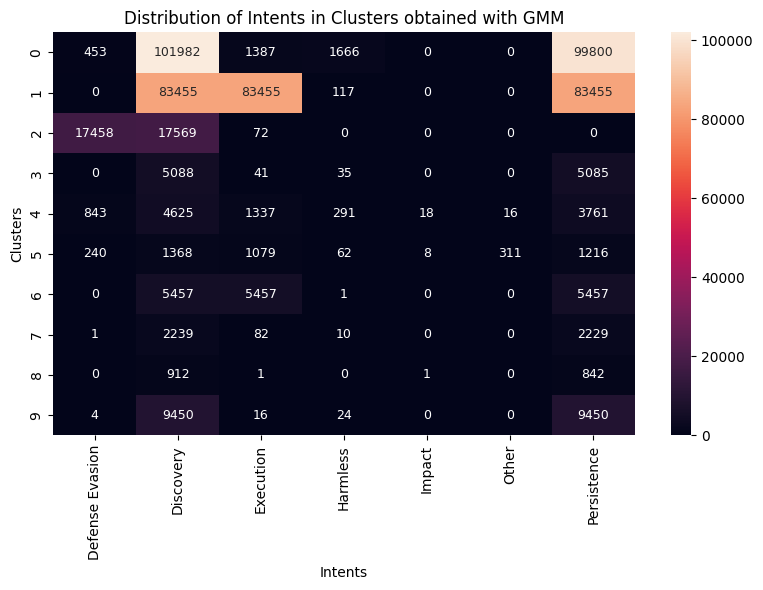

Set_Fingerprint,Defense Evasion,Discovery,Execution,Harmless,Impact,Other,Persistence
Cluster,,,,,,,
0,453,101982,1387,1666,0,0,99800
1,0,83455,83455,117,0,0,83455
2,17458,17569,72,0,0,0,0
3,0,5088,41,35,0,0,5085
4,843,4625,1337,291,18,16,3761
5,240,1368,1079,62,8,311,1216
6,0,5457,5457,1,0,0,5457
7,1,2239,82,10,0,0,2229
8,0,912,1,0,1,0,842


In [62]:
cluster_df_gmm_intents = pd.DataFrame({'Set_Fingerprint': df_cluster_exp["Set_Fingerprint"], 'Cluster': df_cluster_exp["cluster_labels_gmm"]})
cluster_distribution_gmm = cluster_df_gmm_intents.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(8, 6))
sns.color_palette("magma", as_cmap=True)
sns.heatmap(cluster_distribution_gmm, annot=True, fmt='d', annot_kws={"size": 9})
plt.title('Distribution of Intents in Clusters obtained with GMM')
plt.xlabel('Intents')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()
cluster_distribution_gmm

### 3.5.2 Intents in K-means

In [ ]:
cluster_df_kmeans_intents = pd.DataFrame({'Set_Fingerprint': df_cluster_exp["Set_Fingerprint"], 'Cluster': df_cluster_exp["cluster_labels_kmeans"]})
cluster_distribution_kmeans = cluster_df_kmeans_intents.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(8, 6))
sns.color_palette("magma", as_cmap=True)
sns.heatmap(cluster_distribution_kmeans, annot=True, fmt='d', annot_kws={"size": 9})
plt.title('Distribution of Intents in Clusters obtained with K-means')
plt.xlabel('Intents')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()
cluster_distribution_kmeans